# Question 1: CNNs and Finetuning

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
def unpickle(file):
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt

    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

## Part 1: Download and prepare data

In [ ]:
#True= Training , False= Testing
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

dataloaders = {x: torch.utils.data.DataLoader(datasets.CIFAR10(root='./data', train=x, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=512, shuffle=True,
        num_workers=4, pin_memory=True)
              for x in [True, False]}

dataset = {x:torchvision.datasets.CIFAR10(root='./data', train=x,
                                        download=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]))
          for x in [True, False]}
dataset_sizes={x:len(dataset[x])for x in [True, False]}

class_names = dataset[True].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


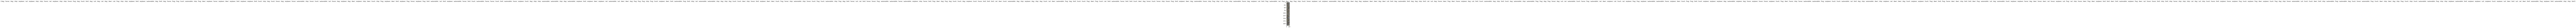

In [ ]:
#True= Training , False= Testing
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders[True]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
dataset_sizes

{False: 10000, True: 50000}

In [ ]:
#True= Training , False= Testing
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in [True, False]:
            if phase == True:
#                 scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == True):
                    outputs = model(inputs)
                    probs, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == True:
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == True:
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == False and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

##Part 2: Use the pretrained Resnet18 model (from trochvision) to extract features.

In [ ]:
import torchvision
import torch.nn as nn
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


###Part 2A: Describe any choices made and report test performance.

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
True Loss: 2.1953 Acc: 0.2138
False Loss: 1.9933 Acc: 0.3024

Epoch 1/24
----------
True Loss: 1.9133 Acc: 0.3306
False Loss: 1.8704 Acc: 0.3450

Epoch 2/24
----------
True Loss: 1.8254 Acc: 0.3645
False Loss: 1.8104 Acc: 0.3749

Epoch 3/24
----------
True Loss: 1.7807 Acc: 0.3831
False Loss: 1.7797 Acc: 0.3848

Epoch 4/24
----------
True Loss: 1.7523 Acc: 0.3913
False Loss: 1.7513 Acc: 0.3964

Epoch 5/24
----------
True Loss: 1.7377 Acc: 0.3946
False Loss: 1.7359 Acc: 0.4002

Epoch 6/24
----------
True Loss: 1.7219 Acc: 0.4012
False Loss: 1.7182 Acc: 0.4064

Epoch 7/24
----------
True Loss: 1.7062 Acc: 0.4098
False Loss: 1.7294 Acc: 0.3995

Epoch 8/24
----------
True Loss: 1.7115 Acc: 0.4060
False Loss: 1.7171 Acc: 0.4067

Epoch 9/24
----------
True Loss: 1.7114 Acc: 0.4084
False Loss: 1.7269 Acc: 0.4065

Epoch 10/24
----------
True Loss: 1.7065 Acc: 0.4074
False Loss: 1.7201 Acc: 0.4047

Epoch 11/24
----------
True Loss: 1.7105 Acc: 0.4044
False Loss: 1.7220 Acc

We used SGD to optimize the final parameter with learning rate at 0.001 and momentum 0.9. We also used nnCrossEntropy Loss for for our criterion.
Accuracy with the pretrained model is around 41%.

###Part 2B: Display the top 5 correct predictions and the top 5 incorrect predictions in each class compactly

Below are the top 5 correctly predicted images for each class.

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    
    fig = plt.figure()

    with torch.no_grad():
        movie_dict = {}
        for i, (inputs, labels) in enumerate(dataloaders[False]):
          if i == 0:
              inputs = inputs.to(device)
              labels = labels.to(device)

              outputs = model(inputs)
              probs, preds = torch.max(outputs, 1)
              #print(i)
              movie_dict[i, labels] = probs
             
              for k in class_names:
                print("Top 5 for class "+k)
                images_so_far = 0
                probs=sorted(probs, reverse=True)
                for j in range(inputs.size()[0]):
                    if class_names[labels[j]]==k and class_names[labels[j]]== class_names[preds[j]]:
                        images_so_far += 1
                        ax = plt.subplot(num_images//1, 2, images_so_far)
                        ax.axis('off')
                        ax.set_title('predicted: {}'.format(class_names[preds[j]])+ ", "+'actual: {}'.format(class_names[labels[j]])+ ", "+'number: {}'.format(images_so_far))
                        imshow(inputs.cpu().data[j])
                        if images_so_far == num_images:
                          break

Top 5 for class airplane


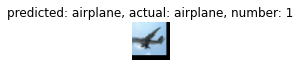

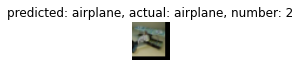

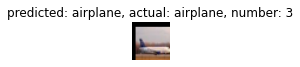

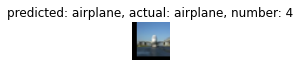

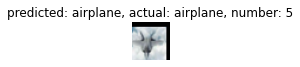

Top 5 for class automobile


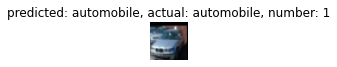

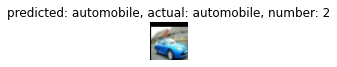

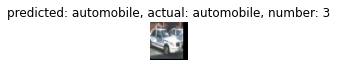

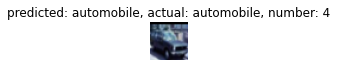

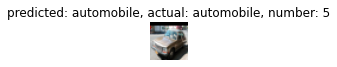

Top 5 for class bird


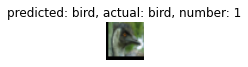

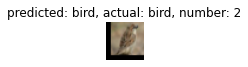

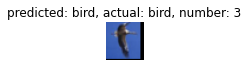

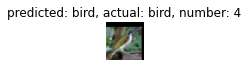

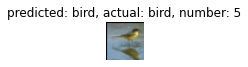

Top 5 for class cat


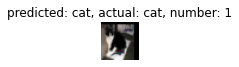

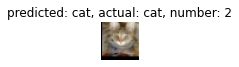

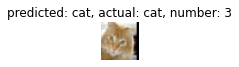

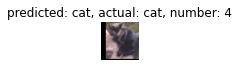

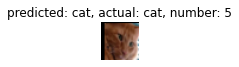

Top 5 for class deer


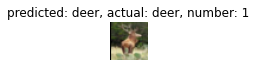

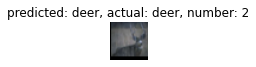

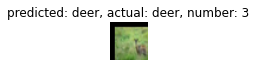

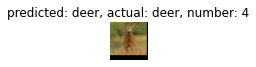

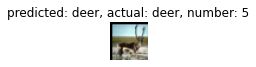

Top 5 for class dog


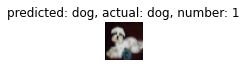

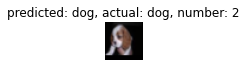

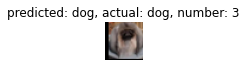

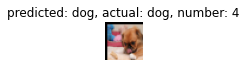

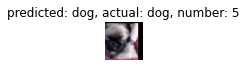

Top 5 for class frog


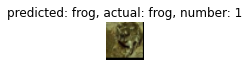

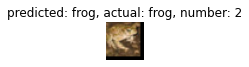

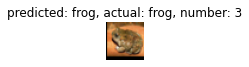

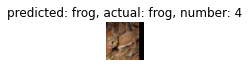

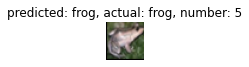

Top 5 for class horse


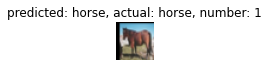

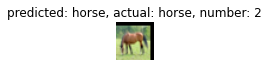

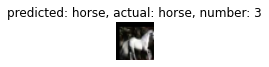

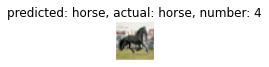

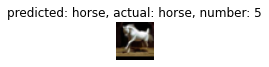

Top 5 for class ship


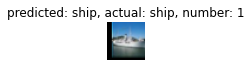

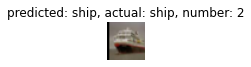

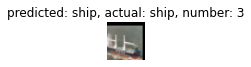

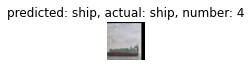

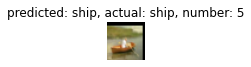

Top 5 for class truck


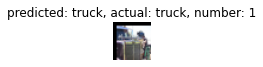

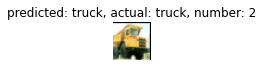

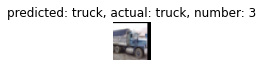

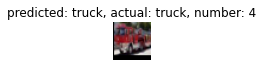

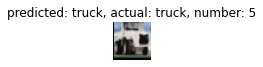

In [ ]:
visualize_model(model_conv, num_images=5)

Below are the bottom 5 incorrectly predicted images for each class.

In [ ]:
def visualize_model_f(model, num_images=6):
    was_training = model.training
    model.eval()
    
    fig = plt.figure()

    with torch.no_grad():
        dictionary = {}
        for i, (inputs, labels) in enumerate(dataloaders[False]):
          if i == 0:
              inputs = inputs.to(device)
              labels = labels.to(device)

              outputs = model(inputs)
              probs, preds = torch.max(outputs, 1)
              #print(i)
              dictionary[i, labels] = probs
             

              for k in class_names:
                print("Bottom 5 for class "+k)
                images_so_far = 0
                probs=sorted(probs, reverse=False)
                for j in range(inputs.size()[0]):
                    if class_names[labels[j]]==k and class_names[labels[j]]!= class_names[preds[j]]:
                        images_so_far += 1
                        ax = plt.subplot(num_images//1, 2, images_so_far)
                        ax.axis('off')
                        ax.set_title('predicted: {}'.format(class_names[preds[j]])+ ", "+'actual: {}'.format(class_names[labels[j]])+ ", "+'number: {}'.format(images_so_far))
                        imshow(inputs.cpu().data[j])
                        if images_so_far == num_images:
                          break


Bottom 5 for class airplane


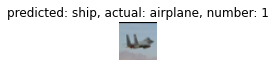

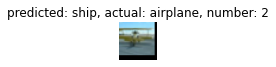

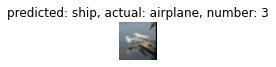

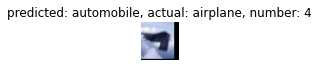

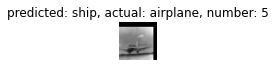

Bottom 5 for class automobile


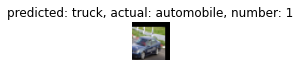

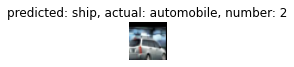

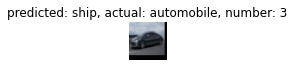

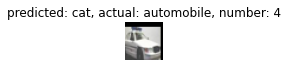

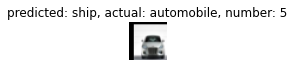

Bottom 5 for class bird


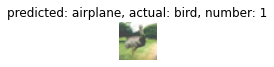

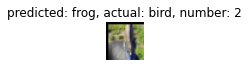

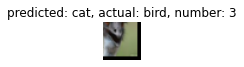

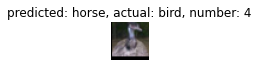

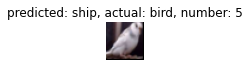

Bottom 5 for class cat


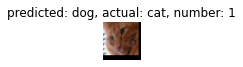

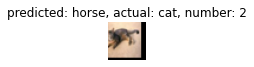

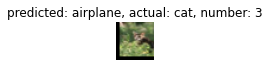

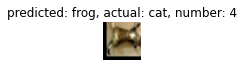

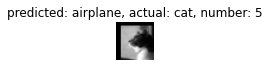

Bottom 5 for class deer


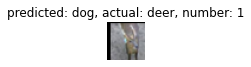

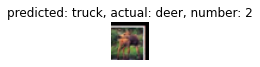

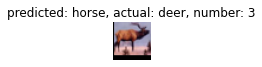

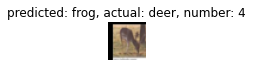

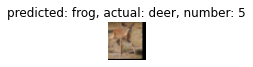

Bottom 5 for class dog


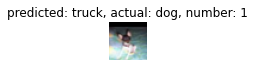

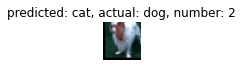

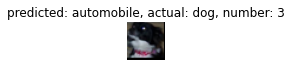

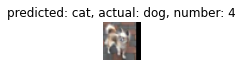

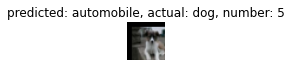

Bottom 5 for class frog


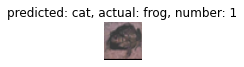

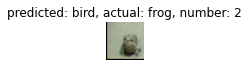

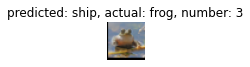

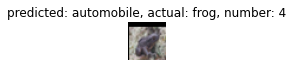

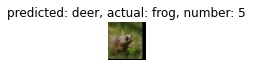

Bottom 5 for class horse


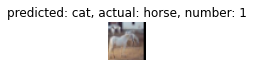

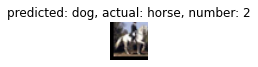

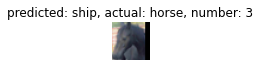

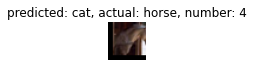

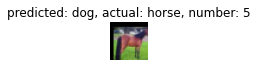

Bottom 5 for class ship


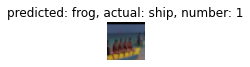

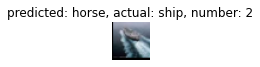

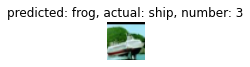

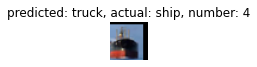

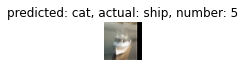

Bottom 5 for class truck


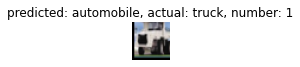

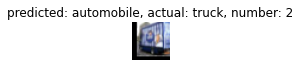

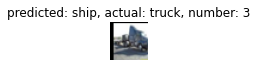

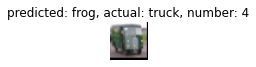

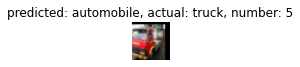

In [ ]:
visualize_model_f(model_conv, num_images=5)



---



## Part 3: Finetune the Resnet18 model

In [ ]:
model_ft = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
True Loss: 1.7548 Acc: 0.3811
False Loss: 1.3589 Acc: 0.5249

Epoch 1/24
----------
True Loss: 1.2166 Acc: 0.5677
False Loss: 1.1303 Acc: 0.6003

Epoch 2/24
----------
True Loss: 1.0521 Acc: 0.6292
False Loss: 1.0042 Acc: 0.6468

Epoch 3/24
----------
True Loss: 0.9540 Acc: 0.6648
False Loss: 0.9465 Acc: 0.6662

Epoch 4/24
----------
True Loss: 0.8809 Acc: 0.6887
False Loss: 0.8958 Acc: 0.6879

Epoch 5/24
----------
True Loss: 0.8326 Acc: 0.7066
False Loss: 0.8484 Acc: 0.7057

Epoch 6/24
----------
True Loss: 0.7876 Acc: 0.7226
False Loss: 0.8224 Acc: 0.7093

Epoch 7/24
----------
True Loss: 0.7607 Acc: 0.7335
False Loss: 0.8133 Acc: 0.7152

Epoch 8/24
----------
True Loss: 0.7576 Acc: 0.7312
False Loss: 0.8153 Acc: 0.7148

Epoch 9/24
----------
True Loss: 0.7464 Acc: 0.7359
False Loss: 0.8099 Acc: 0.7151

Epoch 10/24
----------
True Loss: 0.7497 Acc: 0.7328
False Loss: 0.8154 Acc: 0.7139

Epoch 11/24
----------
True Loss: 0.7437 Acc: 0.7395
False Loss: 0.8076 Acc

We used SGD to optimize the final parameter with learning rate at 0.001 and momentum 0.9. We also used nnCrossEntropy Loss for for our criterion.
Compared to the original pretrained model, the finetuned Resnet18 model has better accuracy. Instead of 41%, it is approximately 72%.

Below are the top 5 correctly predicted images for each class using the finetuned model.

Top 5 for class airplane


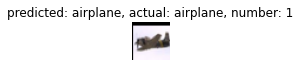

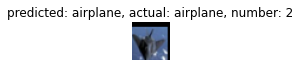

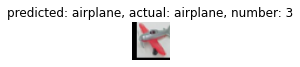

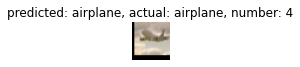

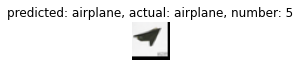

Top 5 for class automobile


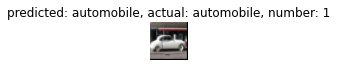

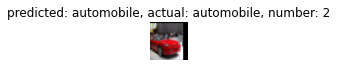

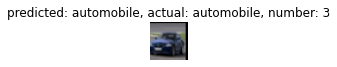

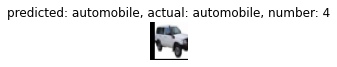

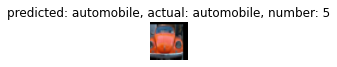

Top 5 for class bird


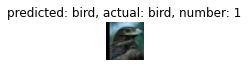

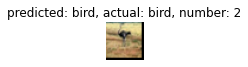

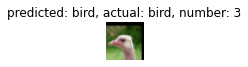

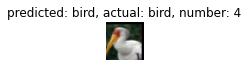

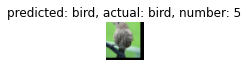

Top 5 for class cat


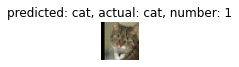

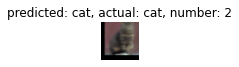

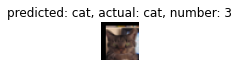

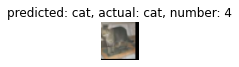

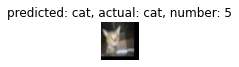

Top 5 for class deer


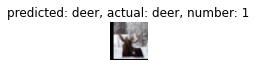

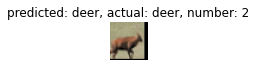

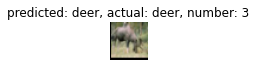

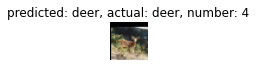

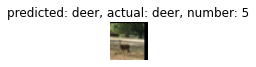

Top 5 for class dog


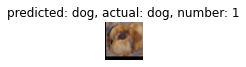

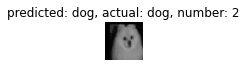

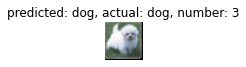

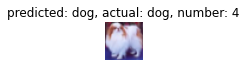

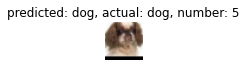

Top 5 for class frog


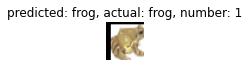

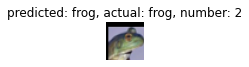

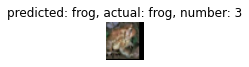

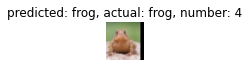

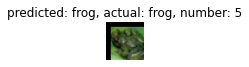

Top 5 for class horse


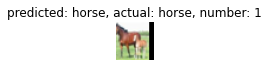

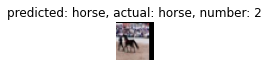

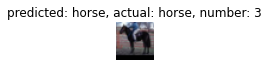

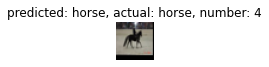

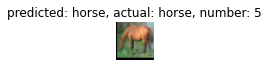

Top 5 for class ship


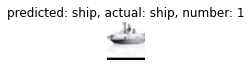

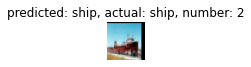

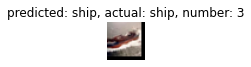

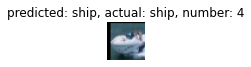

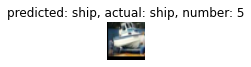

Top 5 for class truck


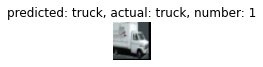

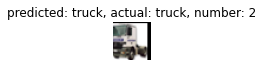

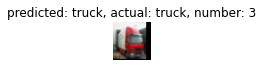

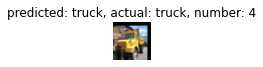

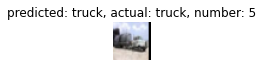

In [ ]:
visualize_model(model_ft, num_images=5)

Below are the bottom 5 incorrectly predicted images for each class using the finetuned model.

Bottom 5 for class airplane


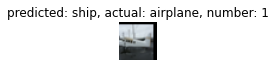

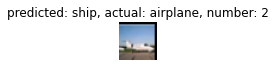

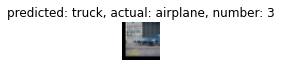

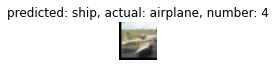

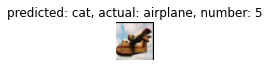

Bottom 5 for class automobile


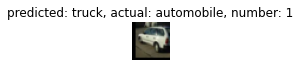

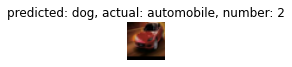

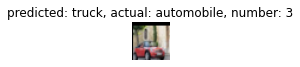

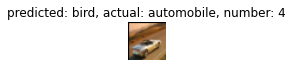

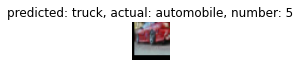

Bottom 5 for class bird


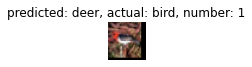

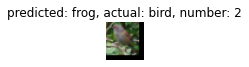

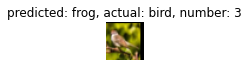

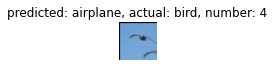

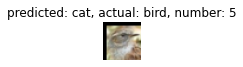

Bottom 5 for class cat


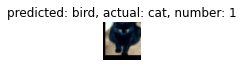

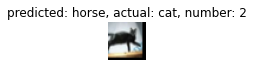

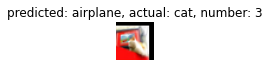

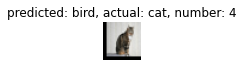

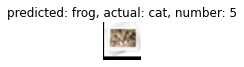

Bottom 5 for class deer


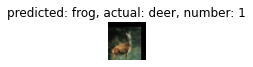

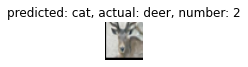

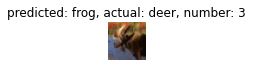

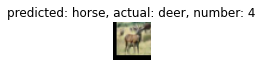

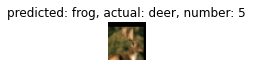

Bottom 5 for class dog


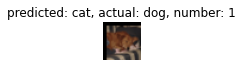

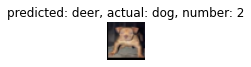

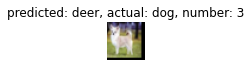

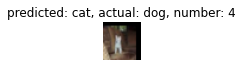

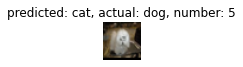

Bottom 5 for class frog


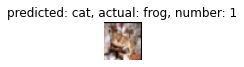

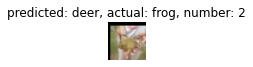

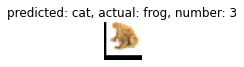

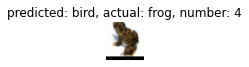

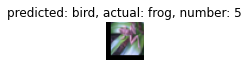

Bottom 5 for class horse


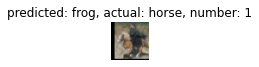

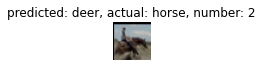

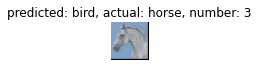

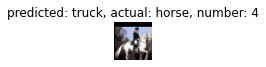

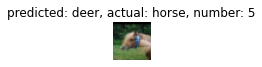

Bottom 5 for class ship


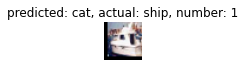

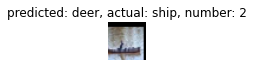

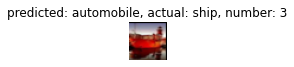

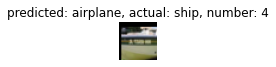

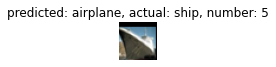

Bottom 5 for class truck


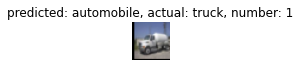

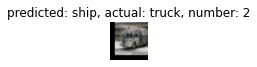

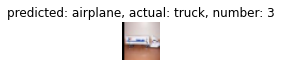

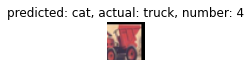

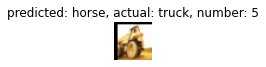

In [ ]:
visualize_model_f(model_ft, num_images=5)

#Question 2: Movie Embeddings

##Part 1: Compute data Xij from the movielens (small) dataset

In [ ]:
#importing required packages
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from torch import nn
from torch import optim
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#reading the data
ratings = pd.read_csv("/content/drive/My Drive/movie_data/ratings.csv")
movie = pd.read_csv("/content/drive/My Drive/movie_data/movies.csv")

In [ ]:
print(movie.shape) # dimension of the movie data
movie.head(5)

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
print(ratings.shape) # dimension of ratings data
ratings.head(5)

(100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
print(len(ratings.rating.unique())) # rating cluster
ratings.rating.unique()

10


array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

In [ ]:
print(len(ratings.userId.unique())) # 610 different users in dataset

610


In [ ]:
print(len(ratings.movieId.unique()))  # 9724 movies in ratings data

9724


In [ ]:
print(len(movie.movieId.unique())) # 9742 movies in movies master data

9742


In [ ]:
# Creating the co-occurrence matrix
movieIDs = np.unique(np.array(ratings["movieId"]))
UserIDs = np.unique(np.array(ratings["userId"]))
                                
co_occur_mat = []
co_occur_mat = pd.DataFrame(0,index = movieIDs, columns = movieIDs)          


In [ ]:
rec = ratings[ratings['rating'] > 3]
for i, df in rec.groupby(['userId']):
    movie_list = list(df.movieId)
    for j in range(len(movie_list)):
        for k in range(j+1,len(movie_list)):
            co_occur_mat.loc[movie_list[j],movie_list[k]] += 1
            co_occur_mat.loc[movie_list[k],movie_list[j]] += 1

In [ ]:
# save the co-occurrence matrix
filename = 'new_occurence matrix'
outfile = open(filename,'wb')

pickle.dump(co_occur_mat,outfile)
outfile.close()

In [ ]:
co_occur_mat = pickle.load(open('/content/drive/My Drive/movie_data/new_occurence_matrix','rb')) # loading the file saved in before

In [ ]:
co_occur_mat.head(5)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
1,0,62,28,0,16,63,14,2,8,66,40,6,2,8,0,47,44,12,32,6,48,12,8,12,42,8,4,8,24,2,14,123,96,47,0,46,0,6,2,2,...,2,0,0,0,0,0,2,6,4,0,0,4,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,62,0,10,0,8,24,14,0,0,24,24,6,2,4,8,10,12,6,28,4,14,6,4,10,8,4,2,4,14,0,10,46,46,10,0,18,0,2,0,2,...,2,0,0,0,0,0,0,8,6,0,0,2,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,28,10,0,0,8,10,10,2,4,8,14,0,0,0,2,14,12,4,8,0,8,6,2,6,6,2,2,4,4,0,4,20,16,8,0,12,0,2,0,2,...,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,16,8,8,0,0,6,8,2,2,4,8,0,0,0,2,8,6,4,4,0,4,2,2,4,4,2,2,0,4,0,4,10,8,8,0,8,0,2,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##Part 2: Optimize function c(v1, ..., vM ) over v1, ..., vM using gradient descent (using pytorch or tensorflow).

In [ ]:
#Converting the co occurence matrix to tensor
co_occur_mat = np.array(co_occur_mat)
movie_tensor = torch.from_numpy(co_occur_mat)
movie_tensor = movie_tensor.type(torch.DoubleTensor)

In [ ]:
#generating v vectors with normally distributed normal data
vmat = np.random.normal(0,0.1, (9724,9724))
vmat_tensor = torch.from_numpy(vmat)

In [ ]:
#Using pytroch linearreg model for gradient descent
class LinReg(nn.Module):
    def __init__(self, idim, odim):
        super().__init__()
        self.beta = nn.Parameter(torch.randn(idim, odim))
        
    def forward(self, X):
        return self.beta

###2A: Plot the loss as a function of iteration for various learning rates

In [ ]:
#Setting parameters for the model
learnrate=[0.00001,0.000001]
loss_all=[]
iter_all=[]
for j in learnrate:
  model = LinReg(9724,300)
  movie_tensor = torch.from_numpy(co_occur_mat)
  movie_tensor = movie_tensor.type(torch.DoubleTensor)
  print ("Model with" + ' ' + str(j) + ' ' + 'learning rate')
  criterion = nn.MSELoss(reduction = 'sum')
  optimizer = optim.SGD(model.parameters(), lr=j)
  # Train step for 1000 iterations
  for i in range(800):
      model.train()
      optimizer.zero_grad()

      coef_vec = model(movie_tensor)
      y_pred = torch.matmul(coef_vec,coef_vec.t())
      y_pred_tensor = y_pred.type(torch.DoubleTensor)
    
      #print(y_pred.shape)
      loss = criterion(y_pred_tensor, movie_tensor)
      loss.backward()
      optimizer.step()

      #Eval
      model.eval() 
      with torch.no_grad():
          y_pred = model(movie_tensor) 

      
      if i % 50 == 0:
              print ("iteration %d: loss %f" % (i, loss))
              iter_all.append(i)
              loss_all.append(loss)

Model with 1e-05 learning rate
iteration 0: loss 29821517649.297783
iteration 50: loss 43519177.376694
iteration 100: loss 21424460.507817
iteration 150: loss 14836482.962301
iteration 200: loss 11946377.812706
iteration 250: loss 10408148.375887
iteration 300: loss 9498099.208562
iteration 350: loss 8922044.560706
iteration 400: loss 8537956.534963
iteration 450: loss 8270722.382313
iteration 500: loss 8078302.418553
iteration 550: loss 7935475.822212
iteration 600: loss 7826401.087710
iteration 650: loss 7741019.089961
iteration 700: loss 7672858.886237
iteration 750: loss 7617599.427485
Model with 1e-06 learning rate
iteration 0: loss 29692524328.851696
iteration 50: loss 1205342729.065916
iteration 100: loss 419702520.255200
iteration 150: loss 228799231.487851
iteration 200: loss 149958160.016995
iteration 250: loss 109749910.050296
iteration 300: loss 85864605.078119
iteration 350: loss 70260918.364206
iteration 400: loss 59444725.463350
iteration 450: loss 51561345.305487
iterat

We chose to compare the loss for learning rates of 0.00001 (1e-05) and 0.000001 (1e-06), while keeping the optimizer as SGD. The loss for 
a learning rate of 1e-05 decreased and converged much faster, making it a better choice.

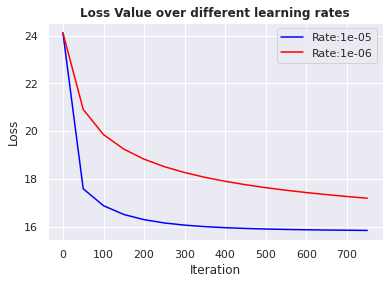

In [ ]:
#Plotting the loss
import seaborn as sns 
sns.set()
ax=plt.plot(iter_all[:16], np.log(loss_all[:16]), "blue",label="Rate:1e-05")
plt.plot(iter_all[16:], np.log(loss_all[16:]), "red",label="Rate:1e-06")
plt.legend()
plt.title('Loss Value over different learning rates',weight='bold')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

###2B: Plot the loss as a function of iteration for various optimizers

In [ ]:
#Converting the co occurence matrix to tensor
co_occur_mat = np.array(co_occur_mat)
movie_tensor = torch.from_numpy(co_occur_mat)
movie_tensor = movie_tensor.type(torch.DoubleTensor)

In [ ]:
#generating v vectors with normally distributed normal data
vmat = np.random.normal(0,0.1, (9724,9724))
vmat_tensor = torch.from_numpy(vmat)

In [ ]:
#Using pytroch linearreg model for gradient descent
class LinReg(nn.Module):
    def __init__(self, idim, odim):
        super().__init__()
        self.beta = nn.Parameter(torch.randn(idim, odim))
        
    def forward(self, X):
        return self.beta

#Setting parameters for the model
loss_df=[]
iter_df=[]

for j in range(2):
  # Train step for 1000 iterations
  model = LinReg(9724,300)
  opt = [optim.SGD(model.parameters(), lr=0.00001), optim.Adam(model.parameters(), lr=0.00001)]
  z=opt[j]
  movie_tensor = torch.from_numpy(co_occur_mat)
  movie_tensor = movie_tensor.type(torch.DoubleTensor)
  criterion = nn.MSELoss(reduction = 'sum')
  print("Model with" + ' ' + str(z)[:3] + ' ' + 'optimizer')
  for i in range(800):
      model.train()
      z.zero_grad()

      coef_vec = model(movie_tensor)
      y_pred = torch.matmul(coef_vec,coef_vec.t())
      y_pred_tensor = y_pred.type(torch.DoubleTensor)
    
      #print(y_pred.shape)
      loss = criterion(y_pred_tensor, movie_tensor)

      loss.backward()
      z.step()

      #Eval
      model.eval() 
      with torch.no_grad():
          y_pred = model(movie_tensor) 
      
      if i % 50 == 0:
              print ("iteration %d: loss %f" % (i, loss))
              iter_df.append(i)
              loss_df.append(loss)

Model with SGD optimizer
iteration 0: loss 29682432358.216755
iteration 50: loss 43573419.640869
iteration 100: loss 21429239.611411
iteration 150: loss 14876548.339579
iteration 200: loss 11989209.887811
iteration 250: loss 10441822.750409
iteration 300: loss 9521431.463970
iteration 350: loss 8937600.705436
iteration 400: loss 8546885.623386
iteration 450: loss 8274514.594857
iteration 500: loss 8078705.277653
iteration 550: loss 7934137.973857
iteration 600: loss 7824625.194497
iteration 650: loss 7739615.170645
iteration 700: loss 7672169.328660
iteration 750: loss 7617639.926326
Model with Ada optimizer
iteration 0: loss 29782109530.295303
iteration 50: loss 29734707736.028316
iteration 100: loss 29687384476.962349
iteration 150: loss 29640166562.031448
iteration 200: loss 29593069979.110786
iteration 250: loss 29546054753.077969
iteration 300: loss 29499114622.761452
iteration 350: loss 29452252024.914436
iteration 400: loss 29405488639.393623
iteration 450: loss 29358877407.1419

Next, we tried different optimizers of SGD and Adam while holding the learning rate constant, and we found that the result is very sensitive to the optimizer. The plot below demonstrates that there is little change in the loss over all iterations with Adam. Our research shows that [Adam can fail to converge as an optimizer](https://arxiv.org/pdf/1904.09237.pdf), which is likely what is happening here. SGD is the better optimizer choice of the two.

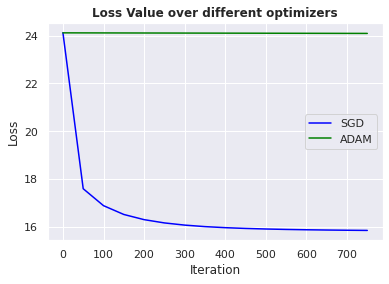

In [ ]:
#Plotting the loss
import seaborn as sns 
sns.set()
plt.plot(iter_df[:16],np.log(loss_df[:16]), "blue",label="SGD")
plt.plot(iter_df[16:],np.log(loss_df[16:]), "green",label="ADAM")
plt.legend()
plt.title('Loss Value over different optimizers',weight='bold')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

##Part 3: Recommend top 10 movies  given movies  ‘Apollo 13’,  ‘Toy Story’, and ‘Home Alone’ .

Strategy: We calculated cosine similarity between movies by using movie vector matrix. Then, we applied sorting function to find the most similar movies and finally we suggested top 10 movies for any specific movie.

In [ ]:
y_np =  y_pred.data.numpy()

In [ ]:
pred = pd.DataFrame(y_np)

coc_mat = pd.DataFrame(co_occur_mat)
rowNamesArr = coc_mat.index
listOfrowNames = list(rowNamesArr)
rowNamesArr

pred.rename(index = dict(zip(pred.index[0:], listOfrowNames)),inplace=True)

pred_numpy = pred.to_numpy()

rowNamesArr1 = movie.iloc[:,0]
listOfrowNames1 = list(rowNamesArr1)

movie.rename(index = dict(zip(movie.index[0:], listOfrowNames1)),inplace=True)

In [ ]:
def recommend(movieId):
    import scipy
    def cos_loop_spatial(matrix, vector):
                neighbors = []
                for row in range(matrix.shape[0]):
                    neighbors.append(scipy.spatial.distance.cosine(vector, matrix[row,:]))
                return neighbors


    p = pd.DataFrame()
    g = c.loc[movieId,:]
    h = g.to_numpy()
    f = pd.DataFrame(cos_loop_spatial(d,h))

    f.rename(index = dict(zip(f.index[0:], listOfrowNames)),inplace=True)
    f.columns = ['col1']
    sort_by_score = f[(f['col1'] < 1) | (f['col1'] == 1)]
    sort_by_score1 = sort_by_score.sort_values('col1',ascending=False)
    fin = sort_by_score1.nlargest(15, 'col1')
    predicted = pd.merge(fin, movie, left_index=True, right_index=True)
    
    return predicted

Below are the most similar movie recommendations for Home Alone.

In [ ]:
recommend(586)

,col1,movieId,title,genres
3723,0.999991,3723,Hamlet (1990),Drama
921,0.999983,921,My Favorite Year (1982),Comedy
410,0.999904,410,Addams Family Values (1993),Children|Comedy|Fantasy
3342,0.999900,3342,Birdy (1984),Drama|War
5105,0.999890,5105,Don't Look Now (1973),Drama|Horror|Thriller
626,0.999887,626,"Thin Line Between Love and Hate, A (1996)",Comedy
6816,0.999886,6816,Three O'Clock High (1987),Comedy
945,0.999870,945,Top Hat (1935),Comedy|Musical|Romance
2160,0.999857,2160,Rosemary's Baby (1968),Drama|Horror|Thriller


Below are the most similar movie recommendations for Apollo 13.


In [ ]:
recommend(150)

,col1,movieId,title,genres
2949,0.999969,2949,Dr. No (1962),Action|Adventure|Thriller
8093,0.999965,8093,Shiri (Swiri) (1999),Action|Drama|Romance|Thriller
7371,0.999950,7371,Dogville (2003),Drama|Mystery|Thriller
778,0.999948,778,Trainspotting (1996),Comedy|Crime|Drama
4443,0.999894,4443,Outland (1981),Action|Sci-Fi|Thriller
5212,0.999894,5212,"Octagon, The (1980)",Action
6158,0.999834,6158,"Jungle Book 2, The (2003)",Animation|Children
2280,0.999814,2280,Clay Pigeons (1998),Crime
3248,0.999806,3248,Sister Act 2: Back in the Habit (1993),Comedy
3785,0.999803,3785,Scary Movie (2000),Comedy|Horror


Below are the most similar movie recommendations for Toy Story.


In [ ]:
recommend(1)

,col1,movieId,title,genres
2022,0.999811,2022,"Last Temptation of Christ, The (1988)",Drama
6945,0.999740,6945,My Architect: A Son's Journey (2003),Documentary
4966,0.999686,4966,"Incredible Shrinking Man, The (1957)",Sci-Fi|Thriller


Different learning rates and different optimizers lead to different outputs, so the predictions would change if we change these attributes. 